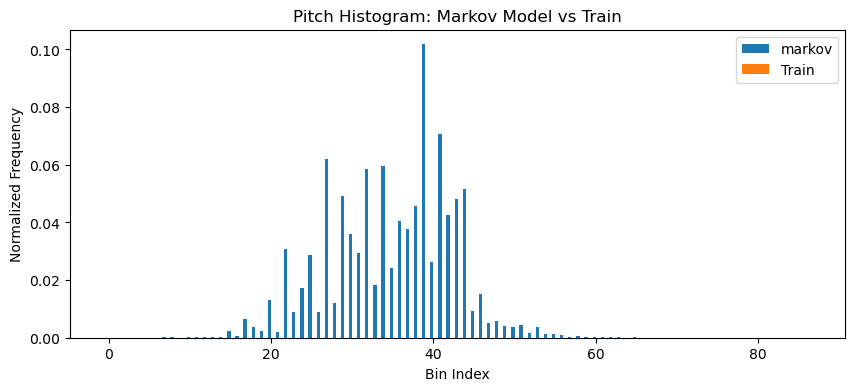

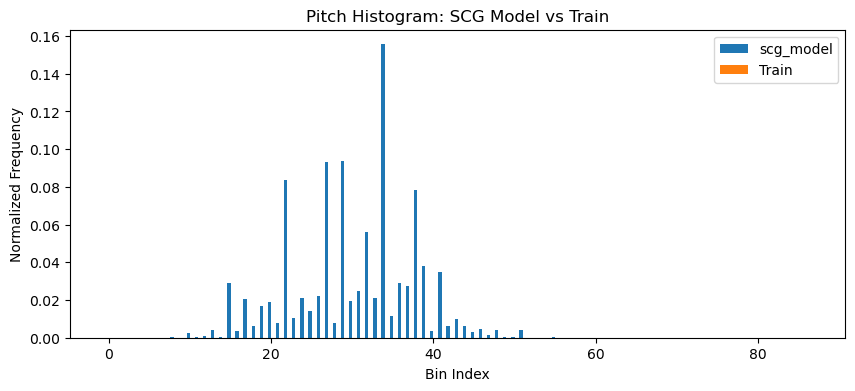

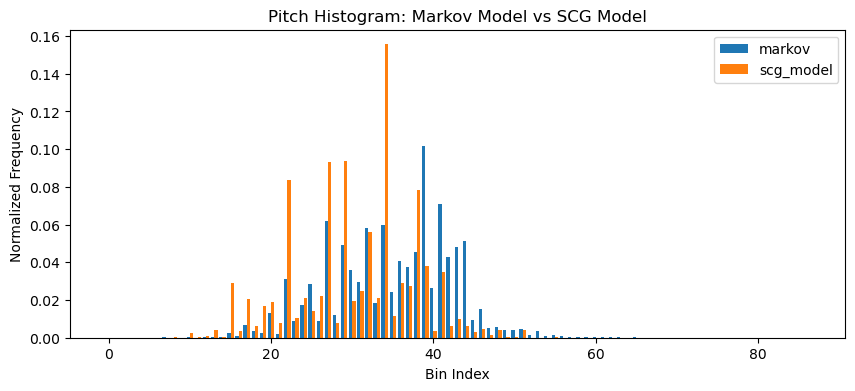

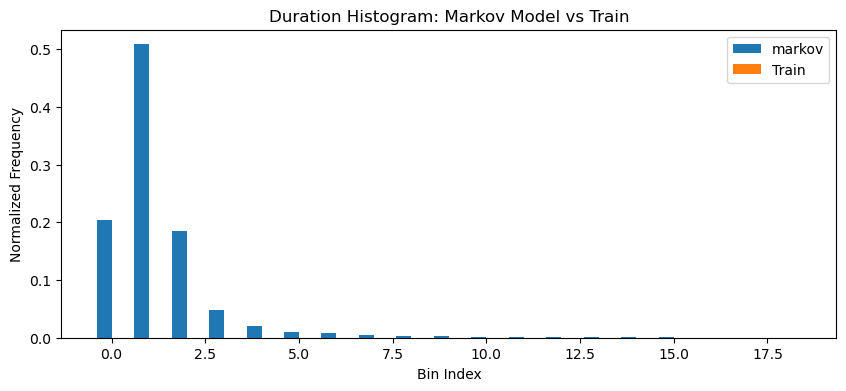

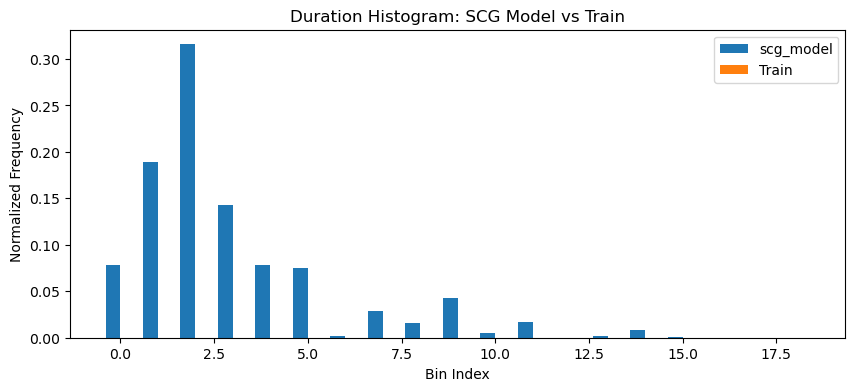

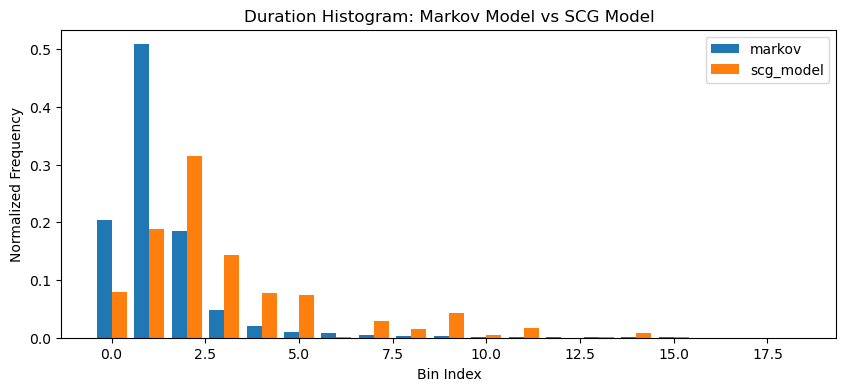

Train Beat STD Mean: 0.0000
markov Beat STD Mean: 0.0000
scg_model Beat STD Mean: 0.0000
markov Self-BLEU (diversity): 0.9783
Model2 Self-BLEU (diversity): 0.8841
Train Tempo STD Mean: 0.0000
Model1 Tempo STD Mean: 0.0000
Model2 Tempo STD Mean: 0.0000


In [1]:
import os
import pretty_midi
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

# ===== Helpers to get MIDI files =====

def get_midi_files_from_folder(folder_path):
    midi_files = []
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.mid', '.midi')):
            midi_files.append(os.path.join(folder_path, file))
    return midi_files

# ===== Parse notes from left hand (track 1) only =====

def parse_lh_notes_pretty_midi(midi_file):
    """
    Extract notes only from second instrument (track 1) - assumed left hand.
    Returns list of (pitch, duration) tuples.
    """
    pm = pretty_midi.PrettyMIDI(midi_file)
    if len(pm.instruments) <= 1:
        return []
    lh_instrument = pm.instruments[1]
    notes = []
    for note in lh_instrument.notes:
        duration = note.end - note.start
        notes.append((note.pitch, duration))
    return notes

# For model-generated samples, assume same parsing (left hand only)
parse_model_notes = parse_lh_notes_pretty_midi

# ===== Histogram computations (no changes) =====

def get_pitch_histogram(notes, bins=range(21, 109)):
    pitches = [p for p, d in notes]
    hist, _ = np.histogram(pitches, bins=bins)
    hist = hist.astype(float)
    return hist / hist.sum() if hist.sum() > 0 else hist

def get_duration_histogram(notes, bins=None):
    durations = [d for p, d in notes]
    if bins is None:
        bins = np.linspace(0, 2.0, 20)  # durations up to 2 seconds
    hist, _ = np.histogram(durations, bins=bins)
    hist = hist.astype(float)
    return hist / hist.sum() if hist.sum() > 0 else hist

def aggregate_notes_from_midis(midi_files, parser):
    all_notes = []
    for f in midi_files:
        try:
            notes = parser(f)
            all_notes.extend(notes)
        except Exception as e:
            print(f"Failed to parse {f}: {e}")
    return all_notes

# ===== Self-BLEU computation (no changes) =====

def notes_to_pitch_sequence(notes):
    return [p for p, d in notes]

def self_bleu(generated_samples):
    scores = []
    for i, hyp in enumerate(generated_samples):
        refs = [s for j, s in enumerate(generated_samples) if j != i]
        if len(refs) == 0:
            continue
        try:
            score = sentence_bleu(refs, hyp, weights=(0.5, 0.5))
            scores.append(score)
        except:
            pass
    return np.mean(scores) if scores else 0.0

def get_pitch_sequences(midi_files, parser):
    sequences = []
    for f in midi_files:
        notes = parser(f)
        seq = notes_to_pitch_sequence(notes)
        if len(seq) > 0:
            sequences.append(seq)
    return sequences

# ===== Histogram plotting, beat/tempo utils (no change) =====

def plot_histograms(hist1, hist2, label1='markov', label2='SCG_model', title='Histogram comparison'):
    plt.figure(figsize=(10, 4))
    width = 0.4
    x = np.arange(len(hist1))
    plt.bar(x - width/2, hist1, width=width, label=label1)
    plt.bar(x + width/2, hist2, width=width, label=label2)
    plt.title(title)
    plt.xlabel('Bin Index')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()

def get_tempo_std(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    tempos, _ = pm.get_tempo_changes()
    if len(tempos) <= 1:
        return 0.0
    return np.std(tempos)

def aggregate_tempo_std(midi_files):
    tempo_stds = []
    for f in midi_files:
        try:
            std = get_tempo_std(f)
            tempo_stds.append(std)
        except Exception as e:
            print(f"Failed to process {f}: {e}")
    return np.mean(tempo_stds), np.std(tempo_stds)

def get_beat_std(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    beat_times = pm.get_beats()
    if len(beat_times) < 2:
        return 0.0
    beat_intervals = np.diff(beat_times)
    return np.std(beat_intervals)

def aggregate_beat_std(midi_files):
    beat_stds = []
    for f in midi_files:
        try:
            std = get_beat_std(f)
            beat_stds.append(std)
        except Exception as e:
            print(f"Failed to process {f}: {e}")
    return np.mean(beat_stds), np.std(beat_stds)

def aggregate_tempo_stds(midi_files):
    tempo_stds = []
    for f in midi_files:
        try:
            std = get_tempo_std(f)
            tempo_stds.append(std)
        except Exception as e:
            print(f"Failed to process {f}: {e}")
    if not tempo_stds:
        return 0.0, 0.0
    return np.mean(tempo_stds), np.std(tempo_stds)

train_folder = "data_left_hand/"
markov_folder = "generated_lh_by_rh/"
scg_model_folder = "symbolic_conditional/"

train_midis = get_midi_files_from_folder(train_folder)
markov_midis = get_midi_files_from_folder(markov_folder)
su_midis = get_midi_files_from_folder(scg_model_folder)

# Aggregate notes (only left hand for train, left hand for models)
train_notes = aggregate_notes_from_midis(train_midis, parse_lh_notes_pretty_midi)
markov_notes = aggregate_notes_from_midis(markov_midis, parse_model_notes)
scg_model_notes = aggregate_notes_from_midis(su_midis, parse_model_notes)

# Compute histograms
pitch_bins = range(21, 109)
duration_bins = np.linspace(0, 2.0, 20)

train_pitch_hist = get_pitch_histogram(train_notes, bins=pitch_bins)
markov_pitch_hist = get_pitch_histogram(markov_notes, bins=pitch_bins)
scg_model_pitch_hist = get_pitch_histogram(scg_model_notes, bins=pitch_bins)

train_duration_hist = get_duration_histogram(train_notes, bins=duration_bins)
markov_duration_hist = get_duration_histogram(markov_notes, bins=duration_bins)
scg_model_duration_hist = get_duration_histogram(scg_model_notes, bins=duration_bins)

# Plot pitch histograms: model vs train
plot_histograms(markov_pitch_hist, train_pitch_hist, 'markov', 'Train', 'Pitch Histogram: Markov Model vs Train')
plot_histograms(scg_model_pitch_hist, train_pitch_hist, 'scg_model', 'Train', 'Pitch Histogram: SCG Model vs Train')
plot_histograms(markov_pitch_hist, scg_model_pitch_hist, 'markov', 'scg_model', 'Pitch Histogram: Markov Model vs SCG Model')

# Plot duration histograms similarly
plot_histograms(markov_duration_hist, train_duration_hist, 'markov', 'Train', 'Duration Histogram: Markov Model vs Train')
plot_histograms(scg_model_duration_hist, train_duration_hist, 'scg_model', 'Train', 'Duration Histogram: SCG Model vs Train')
plot_histograms(markov_duration_hist, scg_model_duration_hist, 'markov', 'scg_model', 'Duration Histogram: Markov Model vs SCG Model')

# Compute Self-BLEU on pitch sequences
markov_sequences = get_pitch_sequences(markov_midis, parse_model_notes)
scg_model_sequences = get_pitch_sequences(su_midis, parse_model_notes)

markov_self_bleu = self_bleu(markov_sequences)
scg_model_self_bleu = self_bleu(scg_model_sequences)

train_beat_mean, train_beat_std = aggregate_beat_std(train_midis)
markov_beat_mean, markov_beat_std = aggregate_beat_std(markov_midis)
scg_model_beat_mean, scg_model_beat_std = aggregate_beat_std(su_midis)

print(f"Train Beat STD Mean: {train_beat_mean:.4f}")
print(f"markov Beat STD Mean: {markov_beat_mean:.4f}")
print(f"scg_model Beat STD Mean: {scg_model_beat_mean:.4f}")

print(f"markov Self-BLEU (diversity): {markov_self_bleu:.4f}")
print(f"Model2 Self-BLEU (diversity): {scg_model_self_bleu:.4f}")

train_tempo_mean, train_tempo_std = aggregate_tempo_stds(train_midis)
model1_tempo_mean, model1_tempo_std = aggregate_tempo_stds(markov_midis)
model2_tempo_mean, model2_tempo_std = aggregate_tempo_stds(su_midis)

print(f"Train Tempo STD Mean: {train_tempo_mean:.4f}")
print(f"Model1 Tempo STD Mean: {model1_tempo_mean:.4f}")
print(f"Model2 Tempo STD Mean: {model2_tempo_mean:.4f}")